# SVM - Climate Sentiment Multiclass Classification

## CS522 Project, Robust Covariance Denoise

### Dataset: 
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

### Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from Common.DataCenter import data_center
from Common.preprocessor import normalize_preprocessing
from Common.UtilFuncs import print_evaluation, print_distribution
import pandas as pd
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

%matplotlib inline
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 96.4 µs (started: 2022-04-17 10:55:35 +08:00)


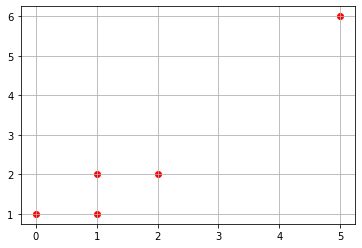

time: 55.9 ms (started: 2022-04-17 10:55:35 +08:00)


In [2]:
df = pd.DataFrame(np.array([[0,1], [1,1], [1,2], [2,2], [5,6]]), columns = ["x", "y"], index = [0,1,2,3,4])
# show data in a scatterplot
plt.scatter(df["x"], df["y"], color = "r")
plt.grid()

In [3]:
# convert dataframe to arrays
data = df[['x', 'y']].values
# instantiate model
model1 = EllipticEnvelope(contamination = 0.1) 
# fit model
model1.fit(data)



EllipticEnvelope()

time: 14.9 ms (started: 2022-04-17 10:55:35 +08:00)


In [4]:
pred1 = model1.predict(data)
print(pred1)

[ 1  1  1  1 -1]
time: 875 µs (started: 2022-04-17 10:55:35 +08:00)


### Text preprocessing

In [5]:
# parameter: original X of training set and test set
# return:  vectorised X of training set and test set
def text_preprocessing(X_train, X_test):
    
    # preprocessing with traditional NLP methodology
    X_train_normalized = normalize_preprocessing(X_train)
    X_test_normalized  = normalize_preprocessing(X_test)
    
    # vectorization
    # Convert texts to vectors by TFIDF
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X_train_vec  = vectorizer.fit_transform(X_train_normalized)
    X_test_vec   = vectorizer.transform(X_test_normalized)
      
    return X_train_vec, X_test_vec

time: 424 µs (started: 2022-04-17 10:55:35 +08:00)


### One-hot encoding, convert the labels to vectors (4 x 1) each

In [6]:
# parameter: original y of training set, original y of test set
# return:  encoded y of training set and test set
def one_hot_encoding(y_train, y_test):
    mlb          = MultiLabelBinarizer()
    y_train_vec  = mlb.fit_transform(map(str, y_train))
    y_test_vec   = mlb.transform(map(str, y_test))
    return y_train_vec, y_test_vec


time: 377 µs (started: 2022-04-17 10:55:35 +08:00)


### Run SVM

In [7]:
# parameter:  vectorised X and encoded y of training set and test set
def run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec):
    # Run SVM - fit and predict
    SVM             = OneVsRestClassifier(LinearSVC(dual=False, class_weight='balanced'), n_jobs=-1)
    SVM.fit(X_train_vec, y_train_vec)
    y_pred          = SVM.predict(X_test_vec)
    return  y_pred


time: 366 µs (started: 2022-04-17 10:55:35 +08:00)


### Do an experiment

In [8]:
# Parameter: original X,y of training set and test set
def do_experiment(X_train, y_train, X_test, y_test):
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # Run SVM and evaluate the results
    y_pred = run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec)

    # Print the evaluation
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])


time: 777 µs (started: 2022-04-17 10:55:35 +08:00)


### Main entry
**Load the database and split it into training set, test set, noisy set, validation set**

# The size of the noise sources

In [9]:

noisy_set_sizes = {
    'mislabeled' : 5000,   # max size: 15000
    'irrelevant' : 5000,   # max size: 34259
    'translated' : 5000,   # max size: 5000
}

# Load the database and split it into training set, test set, noisy set, validation set
dc = data_center("twitter_sentiment_data_clean.csv", train_size = 20000, test_size = 4000, validation_size = 1000,
                 noisy_size = noisy_set_sizes['mislabeled'] if 'mislabeled' in noisy_set_sizes.keys() else 0)

print("####################################################")
print("Total data size: ",       dc.get_len())
print("Total train data size: ", dc.get_train_len())
print("Total test data size: ",  dc.get_test_len())

####################################################
Total data size:  40908
Total train data size:  20000
Total test data size:  4000
time: 138 ms (started: 2022-04-17 10:55:35 +08:00)


**Get the test set for evaluation**

In [10]:
X_test, y_test = dc.get_test()


time: 4.54 ms (started: 2022-04-17 10:55:35 +08:00)


**Set distributions of training set.**

In [11]:
# distribution of training set
train_distribution = None


time: 235 µs (started: 2022-04-17 10:55:35 +08:00)


**Prepare the noisy set.**

In [12]:
lstNoisyInfo    = []
if 'mislabeled' in noisy_set_sizes.keys() and noisy_set_sizes['mislabeled'] > 0:
    lstNoisyInfo.append(("mislabeled",dc.get_noisy_len()))
    print("%d noisy samples of '%s' added" % (dc.get_noisy_len(), 'mislabeled'))

# add the external noisy data (irrelevant texts)
if 'irrelevant' in noisy_set_sizes.keys() and noisy_set_sizes['irrelevant'] > 0:
    # distribution of irrelevant noisy
    irrelevant_noisy_distribution = [0.25, 0.25, 0.25, 0.25]    # None, if use the distribution of original set
    added_size = dc.add_noisy(noisy_source="irrelevant", distribution = irrelevant_noisy_distribution,
                              size = noisy_set_sizes['irrelevant'])
    print("%d noisy samples of '%s' added"  % (added_size, 'irrelevant'))
    lstNoisyInfo.append(("irrelevant",added_size))

# add the external noisy data (translated texts). use the labels of each noisy data
if 'translated' in noisy_set_sizes.keys() and noisy_set_sizes['translated'] > 0:
    added_size = dc.add_noisy(noisy_source="translated", distribution = "reserve_labels",
                              size = noisy_set_sizes['translated'])
    print("%d noisy samples of '%s' added"  % (added_size, 'translated'))
    lstNoisyInfo.append(("translated",added_size))

print("The total size of noisy data is %d"                % dc.get_noisy_len())


5000 noisy samples of 'mislabeled' added
5000 noisy samples of 'irrelevant' added
5000 noisy samples of 'translated' added
The total size of noisy data is 15000
time: 363 ms (started: 2022-04-17 10:55:35 +08:00)


**Run experiments with different training sets, and use the same test set.**

In [13]:
print("-------------- No noisy training sets ----------")
for size in [2000, 4000, 5000, 8000, 10000, 15000, 20000]:
    # Get a training set without noisy data
    X_train, y_train = dc.get_train(size, train_distribution)
    print("* Training set size: %d samples: " % (len(X_train)))
    print_distribution("  Sentiment distribution", y_train)

    # Do an experiment
    do_experiment(X_train, y_train, X_test, y_test)

print("-------------- Noisy training sets -------------")
print("The proportions of the noise sources %s: " % [x[0] for x in lstNoisyInfo],
      [round(x[1]*100/dc.get_noisy_len(),1) for x in lstNoisyInfo])
for size in [(4000, 1000), (8000, 2000), (15000, 5000)]:
    # Get a noisy training set
    X_train, y_train = dc.get_train_with_noisy(size[0], size[1], train_distribution)
    print("* Noisy training set size: %d samples (%d original, %d noisy)" % (len(y_train), size[0], size[1]))
    print_distribution("  Sentiment distribution", y_train)

    # Do an experiment
    do_experiment(X_train, y_train, X_test, y_test)

-------------- No noisy training sets ----------
* Training set size: 2000 samples: 
  Sentiment distribution: 9.4%, 18.3%, 50.2%, 22.1%
  f1 of classes: [0.349, 0.315, 0.711, 0.678]
  micro_f1: 0.626 , macro_f1: 0.513 , weighted_f1: 0.597, macro_precision: 0.592, macro_recall: 0.504
* Training set size: 4000 samples: 
  Sentiment distribution: 9.4%, 18.3%, 50.2%, 22.1%
  f1 of classes: [0.442, 0.371, 0.741, 0.695]
  micro_f1: 0.657 , macro_f1: 0.562 , weighted_f1: 0.635, macro_precision: 0.623, macro_recall: 0.554
* Training set size: 5000 samples: 
  Sentiment distribution: 9.4%, 18.3%, 50.2%, 22.1%
  f1 of classes: [0.466, 0.4, 0.746, 0.709]
  micro_f1: 0.668 , macro_f1: 0.580 , weighted_f1: 0.648, macro_precision: 0.636, macro_recall: 0.570
* Training set size: 8000 samples: 
  Sentiment distribution: 9.4%, 18.3%, 50.2%, 22.1%
  f1 of classes: [0.521, 0.42, 0.758, 0.719]
  micro_f1: 0.682 , macro_f1: 0.604 , weighted_f1: 0.665, macro_precision: 0.648, macro_recall: 0.598
* Training

In [14]:
from Common.SVDUtils import SVD
'''
for size in [(4000, 1000), (8000, 2000), (15000, 5000)]:
    # Here we have the noisy data set
    X_train, y_train = dc.get_train_with_noisy(size[0], size[1], train_distribution)
    print("* Noisy training set size: %d samples (%d original, %d noisy)" % (len(y_train), size[0], size[1]))
    print_distribution("  Sentiment distribution", y_train)
    # Do an experiment
    do_experiment(X_train, y_train, X_test, y_test)
    
    svd = SVD(4000)
    # now I try to remove the noise
    # instantiate model
    model2 = EllipticEnvelope(contamination = 0.1) 
    # fit model
    result = model2.fit_predict(svd.U)
'''

'\nfor size in [(4000, 1000), (8000, 2000), (15000, 5000)]:\n    # Here we have the noisy data set\n    X_train, y_train = dc.get_train_with_noisy(size[0], size[1], train_distribution)\n    print("* Noisy training set size: %d samples (%d original, %d noisy)" % (len(y_train), size[0], size[1]))\n    print_distribution("  Sentiment distribution", y_train)\n    # Do an experiment\n    do_experiment(X_train, y_train, X_test, y_test)\n    \n    svd = SVD(4000)\n    # now I try to remove the noise\n    # instantiate model\n    model2 = EllipticEnvelope(contamination = 0.1) \n    # fit model\n    result = model2.fit_predict(svd.U)\n'

time: 11.6 ms (started: 2022-04-17 10:56:16 +08:00)


In [15]:
# parameter: original X of training set and test set
# return:  vectorised X of training set and test set
def text_preprocessing_fordata(X_train):
    
    # preprocessing with traditional NLP methodology
    X_train_normalized = normalize_preprocessing(X_train)    
    # vectorization
    # Convert texts to vectors by TFIDF
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X_train_vec  = vectorizer.fit_transform(X_train_normalized)

      
    return X_train_vec

time: 336 µs (started: 2022-04-17 10:56:16 +08:00)


In [72]:
trainDF = dc.get_train_with_noisy_df(4000, 1000, train_distribution)
trainDF.reset_index(drop=True, inplace=True)
X_train_vec = text_preprocessing_fordata(trainDF['message'].values)
y_train = trainDF['sentiment'].values

time: 1.53 s (started: 2022-04-17 11:21:13 +08:00)


In [73]:
y_train = np.array(y_train)
# this is sparse matrix

pick_train0 = X_train_vec[y_train==0]
pick_train1 = X_train_vec[y_train==1]
pick_train2 = X_train_vec[y_train==2]
pick_train3 = X_train_vec[y_train==3]
#pick_trainX_dense = pick_trainX.toarray()

time: 4.56 ms (started: 2022-04-17 11:21:14 +08:00)


pick_trainX is a sparse matrix, so the dimension is 84975 which is too high, so here I use svd to decrease the dimension.

In [94]:

svd = SVD(400)
svd.Process(pick_train0)
# now I try to remove the noise
# instantiate model
model2 = EllipticEnvelope(contamination = 0.1, support_fraction=0.8) 
# fit model
result = model2.fit_predict(svd.U)


/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-2704.477346631238561 > -2737.984549939988028). You may want to try with a higher value of support_fraction (current value: 0.799).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-2663.312864263805750 > -2663.408213392162452). You may want to try with a higher value of support_fraction (current value: 0.799).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-2727.732394228222802 > -2754.762134667524151). You may want to try with a higher value

time: 30.8 s (started: 2022-04-17 11:37:22 +08:00)


In [75]:
result[result == 1].shape

(529,)

time: 3.06 ms (started: 2022-04-17 11:22:42 +08:00)


In [76]:
result.shape

(588,)

time: 4.89 ms (started: 2022-04-17 11:22:45 +08:00)


In [96]:
trainDF2 = trainDF[y_train == 0]
resultDF = pd.DataFrame(result, columns=['markasnoise'], index = trainDF2.index)


time: 5.06 ms (started: 2022-04-17 11:39:28 +08:00)


In [78]:
# the noise is marked 1, otherwise 
resultDF[resultDF['markasnoise'] == 1] = 0
resultDF[resultDF['markasnoise']==-1] = 1
trainDF3 = trainDF2.join(resultDF)
trainDF3[trainDF3['noise'] == trainDF3['markasnoise']].shape
trainDF3.shape

(588, 5)

time: 11.4 ms (started: 2022-04-17 11:22:51 +08:00)


In [102]:
def DetectNoise( trainDF, trainVec, y_train, sentimentType, dimension):
    # I only pick the data with the specific type
    pick_trainX = X_train_vec[y_train==sentimentType]    
    svd = SVD(dimension)
    svd.Process(pick_trainX)
    # now I try to remove the noise
    # instantiate model
    model = EllipticEnvelope(contamination = 0.1, support_fraction=0.8) 
    # fit model
    result = model.fit_predict(svd.U)
    pick_trainDF = trainDF[y_train == sentimentType]
    # create result data frame
    resultDF = pd.DataFrame(result, columns=['markasnoise'], index = pick_trainDF.index)
    # change the flag 0: not noise 1: noise
    resultDF[resultDF['markasnoise'] == 1] = 0
    resultDF[resultDF['markasnoise']==-1] = 1
    # append markasnoise column to the train data frame
    newTrainDF = pick_trainDF.join(resultDF)
    return newTrainDF
    

time: 3.21 ms (started: 2022-04-17 11:43:42 +08:00)


In [128]:
def CleanDFNoise(trainDF, X_train_vec, y_train, dimension):
    trainDFs = []
    
    for sentiment in [0,1,2,3]:
        # detect noise
        trainDFForSentiment = DetectNoise(trainDF, X_train_vec, y_train, sentiment, dimension)
        trainDFs.append(trainDFForSentiment)
    # merge the dataframes
    mergedDF = pd.concat(trainDFs)
    # finally I drop the rows marked as noise
    cleanDF = mergedDF[mergedDF['markasnoise'] == 0]
    new_trainVec = X_train_vec[mergedDF['markasnoise'] == 0]
    new_ytrain = y_train[mergedDF['markasnoise'] == 0]
    return (cleanDF, new_trainVec, new_ytrain)


time: 2.85 ms (started: 2022-04-17 12:04:58 +08:00)


In [ ]:
dimension = 400
cleanDF, newTrainVec, newYTrain = CleanDFNoise(trainDF, X_train_vec, y_train, dimension )